In [1]:
import numpy as np
import scipy as sp
import scipy.stats
import itertools
import logging
import matplotlib.pyplot as plt
import pandas as pd
import torch.utils.data as utils
import math
import time
import tqdm

import torch
import torch.optim as optim
import torch.nn.functional as F
from argparse import ArgumentParser
from torch.distributions import MultivariateNormal

import torch.nn as nn
import torch.nn.init as init

In [ ]:
f_rnd = pd.read_hdf("/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_rnd.h5")
f_3prong = pd.read_hdf("/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_3prong_rnd.h5")
f_purebkg = pd.read_hdf("/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_background.h5")

In [2]:
f_BB1 = pd.read_hdf("/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_BB1_rnd.h5")
f_BB2 = pd.read_hdf("/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_BB2.h5")
f_BB3 = pd.read_hdf("/data/t3home000/spark/QUASAR/preprocessing/conventional_tau_BB3.h5")


In [3]:
dt = f_BB2.values

In [4]:
correct = (dt[:,3]>0) &(dt[:,19]>0)
dt = dt[correct]
for i in range(13,19):
    dt[:,i] = dt[:,i]/dt[:,3]
    
for i in range(29,35):
    dt[:,i] = dt[:,i]/(dt[:,19])
        
        
correct = (dt[:,29]>=0) &(dt[:,29]<=1)&(dt[:,30]>=0) &(dt[:,30]<=1)&(dt[:,31]>=0) &(dt[:,31]<=1)&(dt[:,32]>=0) &(dt[:,32]<=1)&(dt[:,33]>=0) &(dt[:,33]<=1)&(dt[:,34]>=-0.01) &(dt[:,34]<=1)
dt = dt[correct]

In [5]:
bb_mass = dt[:,0]

In [6]:
bb_j1trim = dt[:,3] * dt[:,13]

In [7]:
bb_j2trim = dt[:,19] * dt[:,29]

In [8]:
bb_j1raw = dt[:,3]

In [9]:
dt_rnd = f_rnd.values

NameError: name 'f_rnd' is not defined

In [ ]:
rnd_idx = dt_rnd[:,-1]

In [ ]:
#improve purity of trainig by only selecting properly reconstructed jets 

In [ ]:
plt.hist(bb_j1trim)

# APPLY PRESELECTION BEFORE DOING THE FIT TO THE LDA

In [ ]:
np.finfo(np.float32).max

In [ ]:
bkgloss_0 = np.load(f'../data_strings/bkgae_rndbkg_loss_bb1.npy')
sigaeloss_0 = np.load(f'../data_strings/sigae_2prong_loss_bb1.npy')

In [11]:
def generate_X(whichsample):
    #bkgloss_0 = np.load(f'../data_strings/bkgae_rndbkg_loss_{whichsample}.npy')
    bkgloss_1 = np.load(f'../data_strings/bkgae_purebkg_withmass_turnonselection_Huberloss_beta1_WAICloss_{whichsample}.npy')
    sigaeloss_0 = np.load(f'../data_strings/sigae_2prong_withmassNORAWJETMASS_turnonselection_MSEloss_beta1_WAICloss_{whichsample}.npy')
    sigaeloss_1 = np.load(f'../data_strings/sigae_3prong_withmassNORAWJETMASS_turnonselection_MSEloss_beta1_WAICloss_{whichsample}.npy')
    
    bkgloss_1[bkgloss_1 > 1e6 ] = 1e6
    sigaeloss_0[sigaeloss_0 > 1e6 ] = 1e6
    sigaeloss_1[sigaeloss_1 > 1e6 ] = 1e6
    
    #print(np.max(bkgloss_0))
    print(np.max(bkgloss_1))
    print(np.max(sigaeloss_0))
    print(np.max(sigaeloss_1))
    
    
    return np.column_stack((bkgloss_1,sigaeloss_0,sigaeloss_1))

In [ ]:
X = np.vstack((generate_X('rndbkg'),generate_X('purebkg'),generate_X('2prong'),generate_X('3prong')))

In [ ]:
X.shape

In [ ]:
def get_len(whichsample):
    bkgloss_0 = np.load(f'../data_strings/bkgae_{whichsample}_loss_rndbkg.npy')
    bkgloss_1 = np.load(f'../data_strings/bkgae_{whichsample}_loss_purebkg.npy')
    sigaeloss_0 = np.load(f'../data_strings/sigae_2prong_loss_2prong.npy')
    sigaeloss_1 = np.load(f'../data_strings/sigae_2prong_loss_3prong.npy')
    return len(bkgloss_0), len(bkgloss_1), len(sigaeloss_0), len(sigaeloss_1)

In [ ]:
get_len('rndbkg')

In [ ]:
y_rndbkg  = np.zeros(938331)
y_purebkg = np.zeros(930647)
y_2prong  = np.ones(57042)
y_3prong  = np.ones(58822)
Y = np.concatenate((y_rndbkg,y_purebkg,y_2prong,y_3prong),axis=0)

In [ ]:
Y.shape

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis

In [ ]:
clf = QuadraticDiscriminantAnalysis()

In [ ]:
clf.fit(X, Y)

In [ ]:
p3sig = generate_X('2prong')

In [12]:
BB1 = generate_X('bb2')

1000000.0
15370.574
1000000.0


In [ ]:
plt.scatter(BB1[:1000,0],BB1[:1000,1])
plt.xlim([0,200])
plt.ylim([0,200])

In [ ]:
BB1.shape

In [ ]:
BB1_prob = clf.predict_proba(BB1)

In [ ]:
bb1_index = np.where(BB1_prob[:,1]>0.91)[0]

In [ ]:
plt.hist(BB1[:,1],bins=np.linspace(0,1000,1000));
plt.xscale('log')
plt.yscale('log')

# BLACK BOX 1

In [ ]:
#bb1_index = np.where((BB1[:,0]>23) & (BB1[:,1]<1.5) & ((dt[:,13]>0.9)) & ((dt[:,0]>4000)) )[0]
#bb1_index = np.where((BB1[:,0]>15) & (BB1[:,1]<1.0)   & ((dt[:,0]<5000)) & ((dt[:,0]>3500)))[0]


#####BB1 default cut #####
#bb1_index = np.where((BB1[:,0]>15) & (BB1[:,1]<1.0)  )[0]


##### BB1 with 3 prong prior
#bb1_index = np.where((BB1[:,0]>15) & (BB1[:,2]<.8)  )[0]

### BB1 with both prior

#bb1_index = np.where((BB1[:,0]>15) & (BB1[:,1]<1.0) & (BB1[:,2]<.8)  )[0]

# BLACK BOX 2

In [447]:
#####BB2 2prong prior #####
#bb1_index = np.where((BB1[:,0]>8.6) & (BB1[:,1]<0.5)  )[0]
       # 2prong prior with trimmed mass cuts
#bb1_index = np.where((BB1[:,0]>10) & (BB1[:,1]<1.1) & (bb_j2trim> 200) &(bb_j1trim>600))[0]

#####BB2 3 prong prior
#bb1_index = np.where((BB1[:,0]>10.3) & (BB1[:,2]<.5)  )[0]
     #3prong prior with trimmed mass cuts
#bb1_index = np.where((BB1[:,0]>8) & (BB1[:,2]<1.5)  & (bb_j2trim> 200) &(bb_j1trim>600) )[0]

###### BB2 with both prior
bb1_index = np.where((BB1[:,0]>19) & (BB1[:,1]<1.2) & (BB1[:,2]<1.2)  )[0]

# Black Box 3

In [448]:
#####BB3 2prong prior #####
#bb1_index = np.where((BB1[:,0]>6) & (BB1[:,1]<.8)  )[0]
       # 2prong prior with trimmed mass cuts
#bb1_index = np.where((BB1[:,0]>6) & (BB1[:,1]<1.1) & (bb_j1trim> 500) &(bb_j2trim>200))[0]

#####BB3 3 prong prior

#bb1_index = np.where((BB1[:,0]>8) & (BB1[:,2]<.6)  )[0]
     #3prong prior with trimmed mass cuts
#bb1_index = np.where((BB1[:,0]>1) & (BB1[:,2]<.6)  & (bb_j1trim> 600) &(bb_j2trim>200) )[0]

###### BB3 with both prior
#bb1_index = np.where((BB1[:,0]>10) & (BB1[:,1]<1.3) & (BB1[:,2]<1.3))[0]
        #allprior with tau cut on jet 1
#bb1_index = np.where((BB1[:,0]>10) & (BB1[:,1]<1.3) & (BB1[:,2]<1.3) & (dt[:,5]>0.4) )[0]

In [449]:
#bb1_index = np.where((BB1[:,0]>4.) & ((dt[:,13]>0.6)))[0]

In [ ]:
len(bb1_index)

In [434]:
bb1_index;

In [435]:
import mplhep as hep

In [436]:
import mplhep.label as label_base

In [437]:
plt.style.use(hep.style.CMS)


In [438]:
BBTYPE = 'Black Box 2'
#priorusage = '2prongprior'
#priorusage = '2prongprior_withtrimmedmasscutbyeyeball'
#priorusage = '3prongprior'
#priorusage = '3prongprior_withtrimmedmasscutbyeyeball_j1200j2600'
#priorusage = 'allprior'
priorusage = 'allprior_v2'
BBTYPE_FILENAME = 'BB2'
savedir = 'plots'

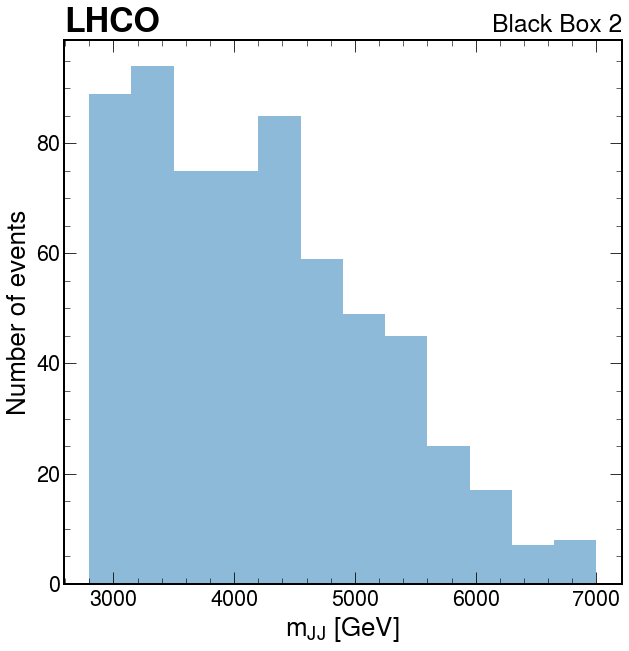

In [446]:
plt.hist(bb_mass[bb1_index],bins=np.linspace(2800,7000,13),alpha=0.5)
#plt.axvline(x=3823)
plt.xlabel(r'$m_{JJ}$ [GeV]')
plt.ylabel('Number of events')
#plt.title('subplot 1')
#hep.cms.cmslabel(data=False, paper=False, year='2017')
hep.label.lumitext(BBTYPE)
label_base._exp_text("LHCO")
#plt.legend(loc='upper right')
plt.savefig(f'../{savedir}/{BBTYPE_FILENAME}_{priorusage}_MJJ.png')
#print(a)

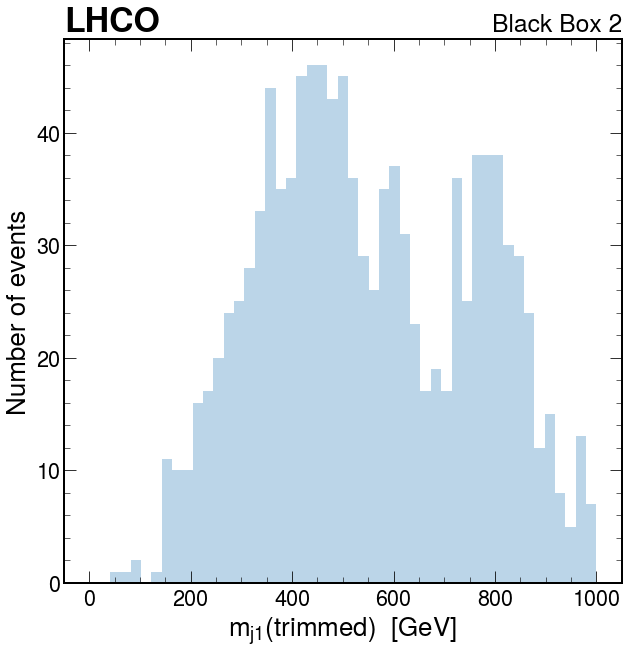

In [409]:
plt.hist(bb_j1trim[bb1_index],bins=np.linspace(0,1000,50),alpha=0.3)
plt.xlabel(r'$m_{j1}(trimmed)$  [GeV]')
plt.ylabel('Number of events')
hep.label.lumitext(BBTYPE)
label_base._exp_text("LHCO")
#plt.axvline(x=732)
plt.savefig(f'../{savedir}/{BBTYPE_FILENAME}_{priorusage}_j1trimmed.png')


In [ ]:
plt.hist(bb_j2trim[bb1_index],bins=np.linspace(0,1000,50),alpha=0.3)
plt.xlabel(r'$m_{j2}(trimmed)$  [GeV]')
plt.ylabel('Number of events')
hep.label.lumitext(BBTYPE)
label_base._exp_text("LHCO")
#plt.axvline(x=378)
plt.savefig(f'../{savedir}/{BBTYPE_FILENAME}_{priorusage}_j2trimmed.png')


In [ ]:
plt.hist(dt[bb1_index,4],bins=np.linspace(0,1,50),density=True,alpha=0.3,label='Selected Events')
plt.hist(dt[:,4],bins=np.linspace(0,1,50),density=True,alpha=0.3,label='Default')
plt.legend(loc='upper right')
hep.label.lumitext(BBTYPE)
label_base._exp_text("LHCO")
plt.xlabel(r'$jet1\ \tau_{21}$')
plt.ylabel('pdf')
plt.savefig(f'../{savedir}/{BBTYPE_FILENAME}_{priorusage}_j1tau21.png')



In [ ]:
plt.hist(dt[bb1_index,5],bins=np.linspace(0,1,50),density=True,alpha=0.3,label='Selected Events')
plt.hist(dt[:,5],bins=np.linspace(0,1,50),density=True,alpha=0.3,label='Default')
plt.legend(loc='upper left')

hep.label.lumitext(BBTYPE)
label_base._exp_text("LHCO")
plt.xlabel(r'$jet1\ \tau_{32}$')
plt.ylabel('pdf')
plt.savefig(f'../{savedir}/{BBTYPE_FILENAME}_{priorusage}_j1tau32.png')


In [ ]:
plt.hist(dt[bb1_index,20],bins=np.linspace(0,1,50),density=True,alpha=0.3,label='Selected Events')
plt.hist(dt[:,20],bins=np.linspace(0,1,50),density=True,alpha=0.3,label='Default')
plt.legend(loc='upper left')
hep.label.lumitext(BBTYPE)
label_base._exp_text("LHCO")
plt.xlabel(r'$jet2\ \tau_{21}$')
plt.ylabel('pdf')
plt.savefig(f'../{savedir}/{BBTYPE_FILENAME}_{priorusage}_j2tau21.png')

In [ ]:
plt.hist(dt[bb1_index,21],bins=np.linspace(0,1,50),density=True,alpha=0.3,label='Selected Events')
plt.hist(dt[:,21],bins=np.linspace(0,1,50),density=True,alpha=0.3,label='Default')
plt.legend(loc='upper left')
hep.label.lumitext(BBTYPE)
label_base._exp_text("LHCO")
plt.xlabel(r'$jet2\ \tau_{32}$')
plt.ylabel('pdf')
plt.savefig(f'../{savedir}/{BBTYPE_FILENAME}_{priorusage}_j2tau32.png')

In [ ]:
from scipy.stats import percentileofscore

In [ ]:
percentiles = [percentileofscore(BB1[:,2], i) for i in BB1[:,2]]

In [ ]:
plt.scatter(BB1[:,0],BB1_prob[:,1])
plt.xscale('log')

In [ ]:
def get_loss(X):
    